In [41]:
import numpy as np
import os
import pandas as pd
from IPython.display import Image, display, HTML, Markdown, FileLink
from pathlib import Path
import matplotlib.pyplot as plt

# Functions

## For Quantitative Results

In [42]:
def get_experiment_df(exp_path, multirun=True, exclude=None):
    variant_dfs = []
    for variant_dir in os.listdir(exp_path):
        if '_bak' in variant_dir:
            continue
        if os.path.isfile(exp_path / variant_dir):
            continue

        # get runs inside each variant_dir 
        run_dirs = [run_dir for run_dir in os.listdir(exp_path / variant_dir)
                if '.yaml' not in run_dir]
        if len(run_dirs) == 0:
            continue

        # get metrics from each run
        run_dfs = []
        if multirun:
            for run_dir in run_dirs:
                run_df = pd.read_csv(exp_path / variant_dir / run_dir / 'metrics.csv')
                if exclude is not None:
                    run_df = run_df[~run_df['object_name'].isin([exclude])]
                # Add run dir as another column
                run_df['run'] = [run_dir for _ in range(len(run_df))]
                run_dfs.append(run_df)
        else:
            run_df = pd.read_csv(exp_path / variant_dir / 'metrics.csv')
            if exclude is not None:
                run_df = run_df[~run_df['object_name'].isin([exclude])]
            # Add run dir as another column
            run_df['run'] = [variant_dir for _ in range(len(run_df))]
            run_dfs.append(run_df)
            
        variant_df = pd.concat(run_dfs)
        variant_dfs.append(variant_df)
    exp_df = pd.concat(variant_dfs)
    assert np.all(exp_df.isnull().sum() == 0) # assert no NaNs
    return exp_df


def get_unique_evaluation_scenes(exp_df):
    # Get scenes
    run_names = exp_df.run.unique()
    evals = set()
    for run_name in run_names:
        eval_name = run_name.split('-')[0]
        evals.add(eval_name)
    return evals


def get_htmls_mds(exp_df, evals):
    htmls = []
    mds = []
    for eval_name in evals:
        eval_df = exp_df.loc[exp_df['run'].str.contains(eval_name)]
        eval_df = eval_df.drop('scene_idx', axis=1).groupby(['run'])
        count = eval_df.count()['execution']
        sub_max = count != count.max()
        if sub_max.sum() > 0:
            print(f"Warning: {count.loc[sub_max].index[0]} only has {np.array(count.loc[sub_max])[0]} / {count.max()} trials")
        df = eval_df.mean().round(2).astype(str) + " +/- " + eval_df.std().round(1).astype(str)

        htmls.append((eval_name, HTML(df.to_html())))
        mds.append((eval_name, df.to_markdown()))
    return htmls, mds

    
def get_experiment_results(exp_path, multirun=True, exclude=None):
    exp_df = get_experiment_df(exp_path, multirun=multirun, exclude=exclude)
    evals = get_unique_evaluation_scenes(exp_df)
    htmls, mds = get_htmls_mds(exp_df, evals)
    return exp_df, evals, htmls, mds
    

def print_htmls_mds(htmls, mds):
    # Pretty print
    for (eval_name, html) in htmls:
#         display(Markdown(f'# {eval_name} evaluation'))
        display(html)

    # Print raw for pasting into Notion
    for (eval_name, md) in mds:
#         print(f"# {eval_name} evaluation")
        print(md)
        with open(exp_path / 'results.md', 'w') as f:
            f.write(md)

In [43]:
def get_details(eval_name, variant, exp_df, success=False, num_samples=None, seed=0, show_gif=False):
    # get success and failure cases for specific evals and variants
    # Don't print all of them but get them manually for now, 
    # Since printing all of them is expensive
    eval_df = exp_df.loc[exp_df['run'].str.contains(eval_name)]
    variant_df = eval_df.loc[eval_df['run'].str.contains(f'-{variant}-')]
    full_variant_name = variant_df['run'].iloc[0]
    selection = variant_df['execution'] == success

    # turn into gifs
    success_df = variant_df.loc[selection]
    paths = success_df[["object_name", "scene_idx"]].apply(lambda x: "_".join([str(y) for y in x]), axis=1)

    variant_path_list = list(exp_path.glob(f'*/{full_variant_name}'))
    assert len(variant_path_list) == 1
    variant_path = variant_path_list[0]

    idxs = paths.index
    if num_samples is not None:
        np.random.seed(seed)
        sampled_idxs = np.random.choice(idxs, size=num_samples, replace=False)
    else:
        sampled_idxs = idxs

    # collision vs. no collision
    tbl = np.zeros((1, 2), dtype=int)
    
    collisions_list = []
    collision_grasp_costs = []
    no_collision_grasp_costs = []
    
    ims = []
    for idx in sampled_idxs:
        # Load collision points
        npz_path = variant_path / 'info' / f'{paths[idx]}.npz'
        data = np.load(npz_path, allow_pickle=True)
        num_collision_pts = data['info'][-1]['collide']
        collisions_list.append(num_collision_pts)
#         print(f"Num collision points: {num_collision_pts}")

        # Get grasp cost
        grasp_cost = data['info'][-1]['grasp']
#         grasp_costs_list.append(grasp_cost)
#         print(f"Grasp cost: {grasp_cost:.6f}")
        
        if num_collision_pts > 0:
            collision_grasp_costs.append(grasp_cost)
            col = 0
        else:
            no_collision_grasp_costs.append(grasp_cost)
            col = 1
        tbl[0,col] += 1
        
        # load gif
        if show_gif:
            path = variant_path / 'gifs' / f'{paths[idx]}.gif'
            im = Image(open(path,'rb').read())
            display(im)
            ims.append(im)

    df = pd.DataFrame(tbl, columns = ['collision', 'no collision'])
    return ims, df, collisions_list, collision_grasp_costs, no_collision_grasp_costs

# Results 

## Experiment: 3obj learned acronym

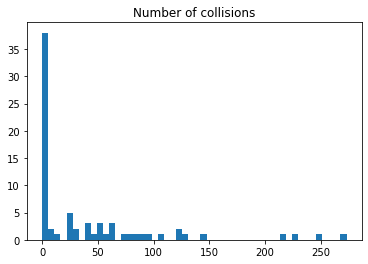

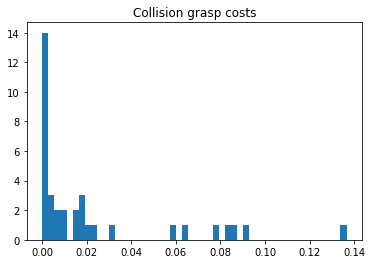

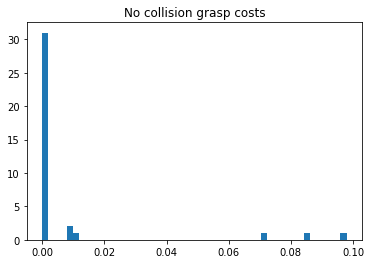

,collision,no collision
0,36,37


In [44]:
root_dir='/media/thomasweng/manifolds/pybullet_eval/multirun'
exp_name = '3obj_learned'
exp_path = Path(f'{root_dir}/{exp_name}')
exp_df, evals, htmls, mds = get_experiment_results(exp_path)
# print_htmls_mds(htmls, mds)

In [ ]:
eval_name = 'acronym'
variant = 'GF_learned_newparams_ctrlpts'

ims, df, collisions_list, collision_grasp_costs, no_collision_grasp_costs \
    = get_details(eval_name, variant, exp_df, success=False)
plt.title("Number of collisions")
plt.hist(collisions_list, bins=50)
plt.show()
plt.title("Collision grasp costs")
plt.hist(collision_grasp_costs, bins=50)
plt.show()
plt.title("No collision grasp costs")
plt.hist(no_collision_grasp_costs, bins=50)
plt.show()
display(df)

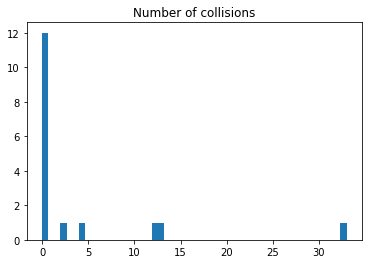

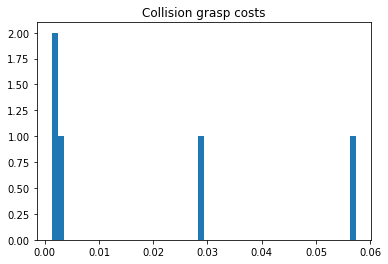

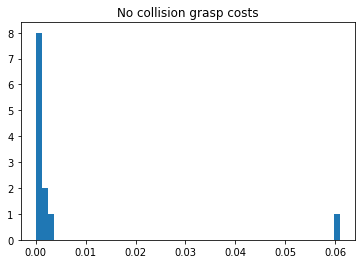

,collision,no collision
0,5,12


In [36]:
ims, df, collisions_list, collision_grasp_costs, no_collision_grasp_costs \
    = get_details(eval_name, variant, exp_df, success=True)
plt.title("Number of collisions")
plt.hist(collisions_list, bins=50)
plt.show()
plt.title("Collision grasp costs")
plt.hist(collision_grasp_costs, bins=50)
plt.show()
plt.title("No collision grasp costs")
plt.hist(no_collision_grasp_costs, bins=50)
plt.show()
display(df)

In [55]:
obj_df = exp_df.drop(columns=['scene_idx']).groupby('object_name')
display(obj_df.mean())
print(obj_df.mean().to_markdown())

,execution,planning,smoothness,collision,time
object_name,,,,,
Bottle_244894af3ba967ccd957eaf7f4edb205_0.012953570261294404,0.166667,0.683333,17.799481,0.011090,18.923248
Bowl_9a52843cc89cd208362be90aaa182ec6_0.0008104428339208306,0.075000,0.208333,72.105429,15.285154,24.869888
Mug_40f9a6cc6b2c3b3a78060a3a3a55e18f_0.0006670441940038386,0.008333,0.250000,58.361800,4.432094,23.451147


| object_name                                                  |   execution |   planning |   smoothness |   collision |    time |
|:-------------------------------------------------------------|------------:|-----------:|-------------:|------------:|--------:|
| Bottle_244894af3ba967ccd957eaf7f4edb205_0.012953570261294404 |  0.166667   |   0.683333 |      17.7995 |   0.0110901 | 18.9232 |
| Bowl_9a52843cc89cd208362be90aaa182ec6_0.0008104428339208306  |  0.075      |   0.208333 |      72.1054 |  15.2852    | 24.8699 |
| Mug_40f9a6cc6b2c3b3a78060a3a3a55e18f_0.0006670441940038386   |  0.00833333 |   0.25     |      58.3618 |   4.43209   | 23.4511 |


## Experiment: Scaling Logmaps More Finely

In [58]:
root_dir='/media/thomasweng/manifolds/pybullet_eval/multirun'
exp_name = 'GF_lmscale_fine'
exp_path = Path(f'{root_dir}/{exp_name}')
exclude='Book_b1611143b4da5c783143cfc9128d0843_0.023835858278933857'
exp_df, evals, htmls, mds = get_experiment_results(exp_path, exclude=exclude)
# print_htmls_mds(htmls, mds)

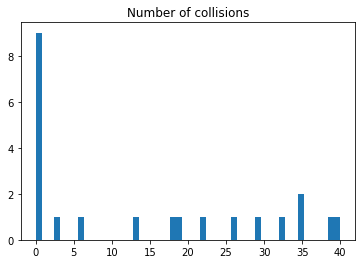

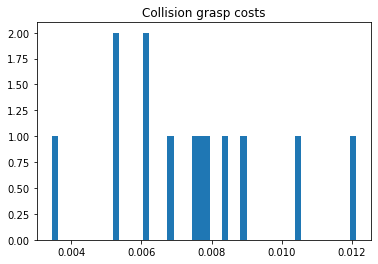

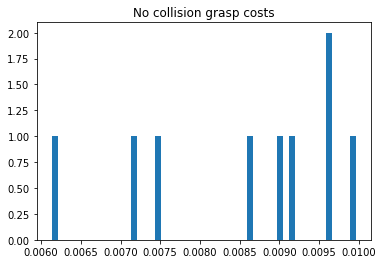

,collision,no collision
0,13,9


In [39]:
eval_name = 'acronym'
variant = 'GF_known_newparams-4.0'
ims, df, collisions_list, collision_grasp_costs, no_collision_grasp_costs \
    = get_details(eval_name, variant, exp_df, success=False)
plt.title("Number of collisions")
plt.hist(collisions_list, bins=50)
plt.show()
plt.title("Collision grasp costs")
plt.hist(collision_grasp_costs, bins=50)
plt.show()
plt.title("No collision grasp costs")
plt.hist(no_collision_grasp_costs, bins=50)
plt.show()
display(df)

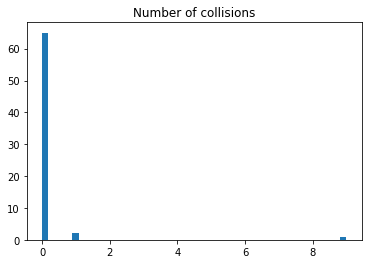

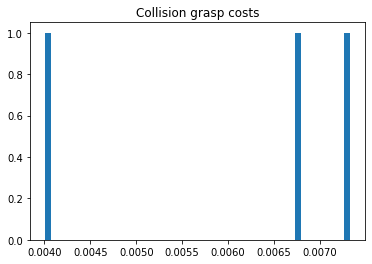

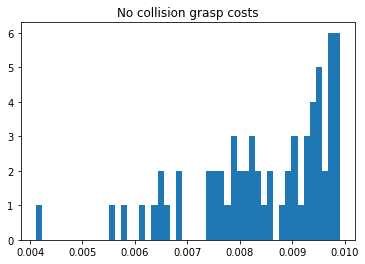

,collision,no collision
0,3,65


In [40]:
ims, df, collisions_list, collision_grasp_costs, no_collision_grasp_costs \
    = get_details(eval_name, variant, exp_df, success=True)
plt.title("Number of collisions")
plt.hist(collisions_list, bins=50)
plt.show()
plt.title("Collision grasp costs")
plt.hist(collision_grasp_costs, bins=50)
plt.show()
plt.title("No collision grasp costs")
plt.hist(no_collision_grasp_costs, bins=50)
plt.show()
display(df)

In [59]:
obj_df = exp_df.drop(columns=['scene_idx']).groupby('object_name')
display(obj_df.mean())
print(obj_df.mean().to_markdown())

,execution,planning,smoothness,collision,time
object_name,,,,,
003_cracker_box,0.937500,0.006944,14.511347,18.827154,71.373763
004_sugar_box,0.930556,0.854167,19.281485,12.224483,21.567697
005_tomato_soup_can,0.409091,0.000000,13.239246,51.268546,73.747059
006_mustard_bottle,0.625000,0.339286,26.550259,67.047091,54.670210
019_pitcher_base,0.779412,0.389706,9.613743,16.735755,47.345551
021_bleach_cleanser,0.795455,0.602273,33.039401,20.446112,47.847687
Bottle_244894af3ba967ccd957eaf7f4edb205_0.012953570261294404,0.916667,0.937500,9.084710,0.018541,30.395925
Bowl_9a52843cc89cd208362be90aaa182ec6_0.0008104428339208306,0.570833,0.766667,8.076568,4.478660,34.180699
Mug_40f9a6cc6b2c3b3a78060a3a3a55e18f_0.0006670441940038386,0.683333,0.691667,9.412979,1.170840,38.397377


| object_name                                                  |   execution |   planning |   smoothness |   collision |    time |
|:-------------------------------------------------------------|------------:|-----------:|-------------:|------------:|--------:|
| 003_cracker_box                                              |    0.9375   | 0.00694444 |     14.5113  |  18.8272    | 71.3738 |
| 004_sugar_box                                                |    0.930556 | 0.854167   |     19.2815  |  12.2245    | 21.5677 |
| 005_tomato_soup_can                                          |    0.409091 | 0          |     13.2392  |  51.2685    | 73.7471 |
| 006_mustard_bottle                                           |    0.625    | 0.339286   |     26.5503  |  67.0471    | 54.6702 |
| 019_pitcher_base                                             |    0.779412 | 0.389706   |      9.61374 |  16.7358    | 47.3456 |
| 021_bleach_cleanser                                          |    0.795455 | 0.60